In [9]:
import numpy as np
import sys
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
sys.path.insert(1,'/home/zhanibek/catkin_ws/src/smart_tray/scripts/')
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook
import pickle
import pandas as pd

from scipy import io as sio

from tqdm.notebook import tqdm

import phri
from phri.utils import *

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


from sklearn import linear_model, datasets

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [11]:

def plot_pose(obs, rot = 'orientation'):
    h = 1
    w = 2
    ylim = 1.6
    xlim = 15

    plt.figure(figsize=(20,h*6))


    print obs['traj_type'], obs['motion_type']

    # Position from camera 1
    plt.subplot(h,w,1)
    plt.plot(obs['pose123']['time_steps'], obs['pose123']['position'], '.', alpha=1)
    plt.legend(['x','y','z'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'],obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.ylim(-1.5, 3.2)
    plt.xlim(0, xlim)


    plt.subplot(h,w,2)
    plt.plot(obs['pose123']['time_steps'], obs['pose123'][rot], '.', alpha=1)
    plt.legend(['x','y','z', 'angle'])
    plt.gca().set_title('Orientation %s %s %s'%(obs['pose123']['frame_id'],obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)
    plt.ylim(-2*np.pi, 2*np.pi)
    
def plot_all_clean(obs, rot = 'orientation'):
    
    h = 5
    w = 2
    ylim = 1.5
    xlim = 15

    plt.figure(figsize=(20,h*6))

    print obs['traj_type'], obs['motion_type']

    # RFT1 1
    plt.subplot(h,w,1)
    plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'], )
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 1 %s %s %s'%(obs['rft1']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    # plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)


    plt.subplot(h,w,2)
    plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 1 %s %s %s'%(obs['rft1']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # RFT 2
    plt.subplot(h,w,3)
    plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 2 %s %s %s'%(obs['rft2']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    # plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)


    plt.subplot(h,w,4)
    plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('RFT 2 %s %s %s'%(obs['rft2']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # Position
    plt.subplot(h,w,5)
    plt.plot(obs['pose123']['time_steps'], obs['pose123']['position'], '.')
    plt.legend(['x','y','z'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.ylim(-1, 3)
    plt.xlim(0, xlim)

    plt.subplot(h,w,6)
    plt.plot(obs['pose123']['time_steps'], obs['pose123'][rot],'.')
    plt.legend(['x','y','z', 'angle'])
    plt.gca().set_title('Position %s %s %s'%(obs['pose123']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # IMU
    plt.subplot(h,w,7)
    plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Accel %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

#     plt.ylim(-ylim, ylim)
    plt.xlim(0, xlim)

    plt.subplot(h,w,8)
    plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Gyro %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()

    plt.xlim(0, xlim)


    # Position from camera 3
    plt.subplot(h,w,9)
    plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
    plt.legend(['x','y','z'])
    plt.gca().set_title('Mag %s %s %s'%(obs['imu']['frame_id'], obs['traj_type'], obs['motion_type']))
    plt.grid()


## Constants

In [12]:
meta_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_0/trial_0_2020-10-12-14-47-43_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_1/trial_1_2020-10-12-14-51-53_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_sanket/trial_0/trial_0_2020-10-12-15-02-32_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_vignesh/trial_0/trial_0_2020-10-12-14-57-11_meta_data_v2.pkl'
]

ann_paths = ['/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Sanket.csv',
             '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Zhanibek.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_1.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_2.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Sanket.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Vignesh.csv']

imu_delay_const = 52345.383253
imu_delays = np.array([0,0,0,0,0,0])
imu_delays[[2,3,4,5]] = imu_delay_const


ipath = 0

meta_data_path = meta_data_paths[ipath]
# ft_data_path = ft_data_paths[ipath]
ann_path = ann_paths[ipath]
trial_pair = os.path.basename(ann_path).split('- ')[-1].split('.')[0]
imu_delay = imu_delays[ipath]

In [13]:
meta_data = pickle.load(open(meta_data_path))

In [14]:
# all_observations = pickle.load(open('segmented_trials.pkl'))

In [15]:
ann_df0 = pd.read_csv(ann_path)
ann_df0.columns = ['obs_num', 'trajectory_type', 'motion_type', 'negotiation', 't0_cam_1_seq',
                  't0_sec', 'tf_cam_1_seq', 'tf_sec', 'duration', 't0_precise','tf_precise',
                  'duration_precise']

time_offset = float(ann_df0['t0_sec'][0])*1000
time_offset

1602467000.0

In [16]:
ann_df = ann_df0[5:]
ann_df

,obs_num,trajectory_type,motion_type,negotiation,t0_cam_1_seq,t0_sec,tf_cam_1_seq,tf_sec,duration,t0_precise,tf_precise,duration_precise
5,1.0,AB1,parallel,NaN,17475,1602467318,17920,1602467330,12,319.3629,330.0816,10.7187
6,2.0,BA2,serial,NaN,18006,1602467332,18401,1602467341,9,332.2502,341.82,9.5698
7,3.0,AB1,serial,NaN,18487,343,18967,356,13,344.1228,356.6791,12.5563
8,4.0,BA1,parallel,NaN,19077,359,19520,372,13,359.1155,372.8226,13.7071
9,5.0,AB2,parallel,NaN,20655,402,21000,413,11,402.7888,411.8186,9.0298
10,6.0,BA1,parallel,NaN,21010,413,21427,424,11,414.3004,424.2445,9.9441
11,7.0,AB2,parallel,NaN,21517,427,21945,439,12,427.3242,437.8941,10.5699
12,8.0,BA2,serial,NaN,22016,440,22349,449,9,440.5338,449.8343,9.3005
13,9.0,AB2,parallel,NaN,22476,453,22820,463,10,452.9302,463.0416,10.1114
14,10.0,BA2,parallel,NaN,23287,476,23654,486,10,477.0748,486.4523,9.3775


### Transformation Constants

In [17]:
# gAS - A to grf
grfA = np.array(
    [[-1, 0, 0, 1.42],
     [0, -1, 0, 0.12],
     [0,  0, 1, 0    ], 
     [0,  0, 0, 1    ]])
# gBS - B to grf
grfB = np.array(
    [[1, 0, 0, 1.27],
     [0, 1, 0, -0.12],
     [0, 0, 1, 0    ], 
     [0, 0, 0, 1    ]])

In [18]:
# Calibrate Magnetometer to Soft-Hard Iron Effects
def calibrate_mag(mag):

    A = np.array(
            [[0.9249, 0.0957, -0.0063],
             [0.0957, 1.0708, -0.0565],
             [-0.0063, -0.0565, 1.0221]]);

    b = np.array([0.0377, 0.1454, -0.0653]);

    expmfs = 0.4166;
    
    mag = np.matmul(mag-b,A)
    
    return mag


def read_rft(tt0,ttf, temp_df):
    
    cut = temp_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = temp_df[cut]

    force =  dict(temp)['force'].to_numpy()
    force = np.array([[f[0],f[1],f[2]] for f in force])

    torque =  dict(temp)['torque'].to_numpy()
    torque = np.array([[f[0],f[1],f[2]] for f in torque])
    
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    frame_id = temp_df.frame_id.iloc[0]
    
    new_force = np.zeros(force.shape)
    new_torque = new_force.copy()
    # Convert to Tray Reference Frame
    # Sensor 1
    if frame_id =='C00300119':        
        new_force[:,0] = force[:,2]
        new_force[:,1] = force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = torque[:,2]
        new_torque[:,1] = torque[:,0]
        new_torque[:,2] = torque[:,1]
    # Sensor 2    
    elif frame_id =='C00300122':
        new_force[:,0] = -force[:,2]
        new_force[:,1] = -force[:,0]
        new_force[:,2] =  force[:,1]
        
        new_torque[:,0] = -torque[:,2]
        new_torque[:,1] = -torque[:,0]
        new_torque[:,2] =  torque[:,1]
        
    res = {'time_steps': tsteps, 'force': new_force, 'torque':new_torque, 'frame_id':frame_id }
    
    return res

def read_imu(tt0, ttf, temp_df):

    cut = imu_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = imu_df[cut]

    accel =  dict(temp)['accel'].to_numpy()
    accel = np.array([[f[0],f[1],f[2]] for f in accel])

    gyro =  dict(temp)['gyro'].to_numpy()
    gyro = np.array([[f[0],f[1],f[2]] for f in gyro])

    mag =  dict(temp)['mag'].to_numpy()
    mag = np.array([[f[0],f[1],f[2]] for f in mag])
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
    # Transform from Sensor Coordinate frame to Tray Coordinates
    new_accel = np.zeros(accel.shape)
    new_gyro = new_accel.copy()
    new_mag = new_gyro.copy()
    
    new_accel[:,0] = accel[:,0]
    new_accel[:,1] = -accel[:,1]
    new_accel[:,2] = -accel[:,2]

    new_mag[:,0] = mag[:,0]
    new_mag[:,1] = -mag[:,1]
    new_mag[:,2] = -mag[:,2]
    
    new_gyro[:,0] = gyro[:,0]
    new_gyro[:,1] = -gyro[:,1]
    new_gyro[:,2] = -gyro[:,2]
    
    res = {'time_steps': tsteps, 'accel': new_accel, 'gyro':new_gyro, 'mag':new_mag, 'frame_id': temp.frame_id.iloc[0]}

    return res


def read_pose(tt0, ttf, pose_df):

    cut = pose_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = pose_df[cut]

    position =  dict(temp)['position'].to_numpy()
    position = np.array([[f[0],f[1],f[2]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan] for f in position ])

    quat =  dict(temp)['quaternion'].to_numpy()
    quat = np.array([[f[0],f[1],f[2],f[3]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan,np.nan] for f in quat])

    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
        
    res = {'time_steps': tsteps, 'position': position, 'quaternion':quat, 'frame_id': pose_df.frame_id.iloc[0]}

    return res


def merge_offline_pos(pos, pos_off,txt='_merged'):
    if len(pos['position'])==0 and np.isnan(pos_off['position']).all():
        return {'time_steps': [], 'position': [], 'quaternion':[], 'frame_id': pos['frame_id']+txt}
    elif len(pos['position'])==0:
        res = {'time_steps': pos_off['time_steps'], 
               'position': pos_off['position'], 
               'quaternion': pos_off['quaternion'], 
               'frame_id': pos_off['frame_id']+txt}
        return res
    elif len(pos_off['position'])==0:
        res = {'time_steps': pos['time_steps'], 
               'position': pos['position'], 
               'quaternion': pos['quaternion'], 
               'frame_id': pos['frame_id']+txt}
        return res
    
    res = {}
    tt = np.concatenate((pos['time_steps'], pos_off['time_steps']))
    pp = np.concatenate((pos['position'], pos_off['position']))
    qq = np.concatenate((pos['quaternion'], pos_off['quaternion']))

    # drop duplicate values
    _, indx = np.unique(tt, return_index=True)

    tt = tt[indx]
    pp = pp[indx]
    qq = qq[indx]
    # sort once more timewise
    sind = np.argsort(tt)
    tt = tt[sind]
    pp = pp[sind]
    qq = qq[sind]
    
    res = {'time_steps': tt, 'position': pp, 'quaternion':qq, 'frame_id': pos['frame_id']+txt}
    return res

def filter_outliers(pose123):
    orientation = pose123['orientation']
    position = pose123['position']
    t = pose123['time_steps']
    
    m_pos = np.array([2., 2., 2.])
    m_orient = np.array([2., 2., 2. ,2.5])
    
    fence_orient = np.quantile(orientation, [0.25, 0.75], axis=0)
    iqr = fence_orient[1]-fence_orient[0]
    fence_orient[0] -= m_orient*iqr
    fence_orient[1] += m_orient*iqr

    fence_pos = np.quantile(position, [0.25, 0.75], axis=0)
    iqr = fence_pos[1]-fence_pos[0]
    fence_pos[0] -= m_pos*iqr
    fence_pos[1] += m_pos*iqr
    
    outlier_mask = ((orientation > fence_orient[1]) + 
                (orientation < fence_orient[0])).any(axis=1)
    outlier_mask += ((position > fence_pos[1]) + 
                     (position < fence_pos[0])).any(axis=1)
    inlier_mask = ~outlier_mask
    
    pose123['time_steps'] = pose123['time_steps'][inlier_mask]
    pose123['position'] = pose123['position'][inlier_mask]
    pose123['orientation'] = pose123['orientation'][inlier_mask]
    
    return pose123


def enforce_angle_range(pos123):
    
    orientation = pos123['orientation']
    # Connect discontinued angle signals. It happens when it exceeds the boundary of [-pi, pi]
    angle = orientation[:,3]
    angle_diff = np.diff(angle)
    N = angle.shape[0]
    thresh = 5.5 #-np.pi/10
    num_iter = 0
    prev_i=0
    while (abs(angle_diff) >= thresh).any() and num_iter<=10:
        disc_inds = np.arange(N-1)[abs(angle_diff)>=thresh]
        ii = disc_inds[0]
        if ii <= prev_i and disc_inds.shape[0]>1:
            ii = disc_inds[1]
        # offset by 2pi    
        si = 1 if angle[:ii+1].mean()>angle[ii+1:-1].mean() else -1
        angle[ii+1:-1] += 2*np.pi*si

        angle_diff = np.diff(angle)        
        num_iter+=1 
        prev_i = ii
    
#     print num_iter
    pos123['orientation'] = orientation
    return pos123

def transform2grfAB(pos123, traj_type):
    
    # Drop nans
    position = pos123['position'].copy()
    quaternion = pos123['quaternion'].copy()
    t = pos123['time_steps'].copy()
    
    # Drop old values
    pos123.pop('position', None)
    pos123.pop('time_steps', None)
    pos123.pop('quaternion', None)

    idx = ~np.isnan(position[:,0])
    
    position = position[idx,:]
    quaternion = quaternion[idx,:]
    t = t[idx]
    
    orientation = np.zeros(quaternion.shape)
    position_new = np.zeros(position.shape)
    for ind in range(t.shape[0]):
        pos = position[ind, :]
        quat = quaternion[ind, :]
        
        gt = g_from_pose({'position': pos, 'orientation':quat})
        # fix left handed coordinate reference frame bug from aruco
        R = gt[:3,:3]
        if np.sign(np.linalg.det(R))==-1:
            gt[:,1] = -gt[:,1]
            print('Left handed Frame is found!')
            
        if 'AB' in traj_type:
            g_new = np.matmul(grfA, gt)
            
        elif 'BA' in traj_type:
            g_new = np.matmul(grfB, gt)
        

        pose_new = pose_from_g(g_new, rotation='axis-angle', zup=True)
        position_new[ind,:] = pose_new['position']
        orientation[ind,:] = pose_new['orientation']
    
#     # make sure that angle starts within [-pi, pi]
#     while abs(orientation[0:10,-1].mean()) > np.pi:
#         if orientation[0:10,-1].mean() > np.pi/2+np.pi/10:
#             orientation[:,-1] -= 2*np.pi
#         elif orientation[0:10,-1].mean() < -(np.pi/2+np.pi/10):
#             orientation[:,-1] += 2*np.pi
    
    
    pos123['position'] = position_new
    pos123['orientation'] = orientation
    pos123['time_steps'] = t
    
    if traj_type=='BA1':
        traj_type = 'AB2'
    elif traj_type=='BA2':
        traj_type = 'AB1'
        
    return pos123, traj_type


In [19]:
total_obs = ann_df.shape[0]
observations = []
rft1_df = meta_data['/RFT_FORCE']
rft2_df = meta_data['/RFT_FORCE_2']
imu_df = meta_data['/imu_data'].copy()
imu_df.time_stamp+=imu_delay

pose1_df = meta_data['/cam1_tray_grf']
pose1_off_df = meta_data['camera_1_grf_offline']

pose2_df = meta_data['/cam2_tray_grf']
pose2_off_df = meta_data['camera_2_grf_offline']

pose3_df = meta_data['/cam3_tray_grf']
pose3_off_df = meta_data['camera_3_grf_offline']

for obs_num in tqdm(range(1,total_obs+1)):

    tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset
    ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset
    
    rft1 = read_rft(tt0,ttf, rft1_df)
    rft2 = read_rft(tt0,ttf, rft2_df)
    
    imu = read_imu(tt0, ttf, imu_df)
    imu['mag'] = calibrate_mag(imu['mag'])
    
    pose1_grf = read_pose(tt0, ttf, pose1_df)
    pose1_off_grf = read_pose(tt0, ttf, pose1_off_df)
    pose1_merged = merge_offline_pos(pose1_grf, pose1_off_grf)
    
    pose2_grf = read_pose(tt0, ttf, pose2_df)
    pose2_off_grf = read_pose(tt0, ttf, pose2_off_df)
    pose2_merged = merge_offline_pos(pose2_grf, pose2_off_grf)
    
    pose3_grf = read_pose(tt0, ttf, pose3_df)
    pose3_off_grf = read_pose(tt0, ttf, pose3_off_df)
    pose3_merged = merge_offline_pos(pose3_grf, pose3_off_grf)
    
    
    pos123 = merge_offline_pos(pose1_merged, pose2_merged, txt='123')
    pos123 = merge_offline_pos(pos123, pose3_merged, txt='123')
    
    traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
    motion_type = ann_df.motion_type[ann_df.obs_num==obs_num].iloc[0]
    
    pos123, traj_type = transform2grfAB(pos123, traj_type)
    pos123 = enforce_angle_range(pos123)
    
    pos123 = filter_outliers(pos123)
    
    pos123 = enforce_angle_range(pos123)
    
    obs = {'rft1': rft1, 'rft2': rft2, 'imu':imu, 
#            'pose1_grf': pose1_grf, 'pose2_grf': pose2_grf, 'pose3_grf': pose3_grf,
#            'pose1_merged':pose1_merged, 'pose2_merged':pose2_merged, 'pose3_merged':pose3_merged,
           'pose123':pos123,
#            'pose1_off_grf': pose1_off_grf, 'pose2_off_grf': pose2_off_grf, 'pose3_off_grf': pose3_off_grf,
           'traj_type':traj_type, 'motion_type': motion_type, 'obs_id':trial_pair+'_'+str(obs_num)}
    
    
    observations.append(obs)

/home/zhanibek/.local/lib/python2.7/site-packages/ipykernel_launcher.py:200: RuntimeWarning:

Mean of empty slice.

/home/zhanibek/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



### Draw 123 merged position

AB1 serial


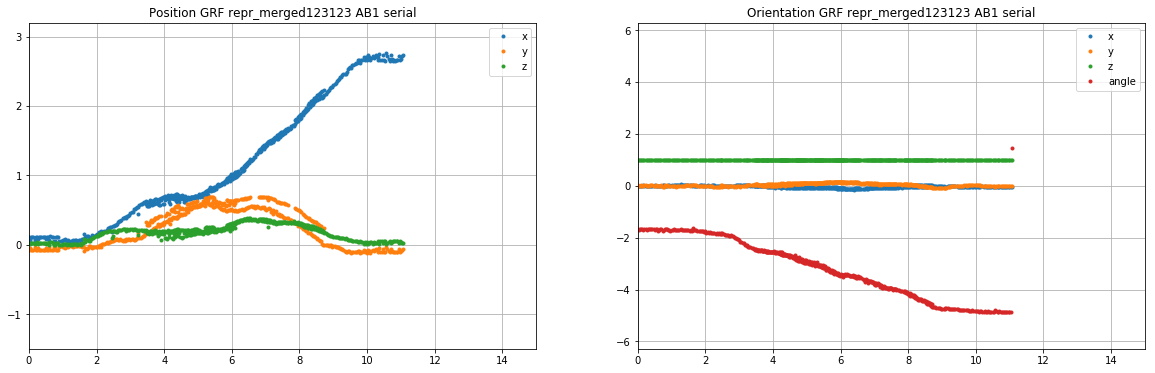

In [22]:
plot_pose(obs)

AB1 parallel
AB1 serial
AB1 serial
AB2 parallel
AB2 parallel
AB2 parallel
AB2 parallel
AB1 serial
AB2 parallel
AB1 parallel
AB1 serial
AB1 serial
AB2 serial
AB2 serial->parallel
AB2 serial
AB1 parallel
AB1 serial
AB1 serial


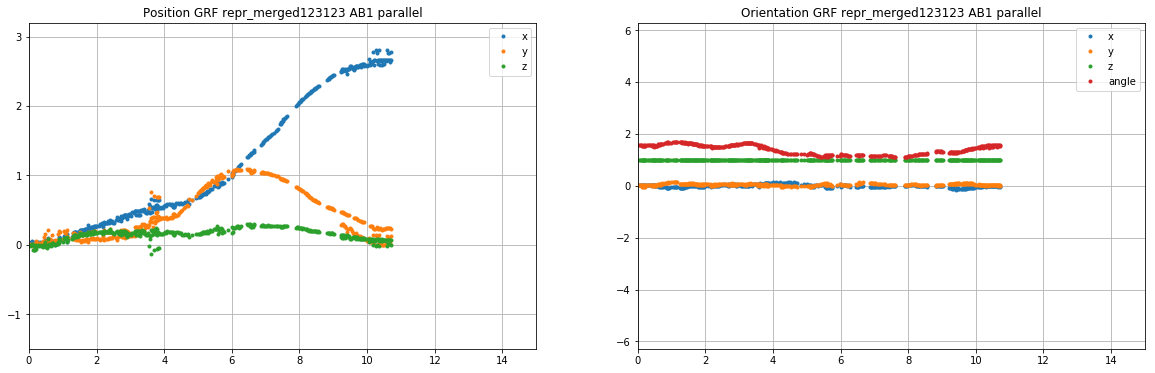

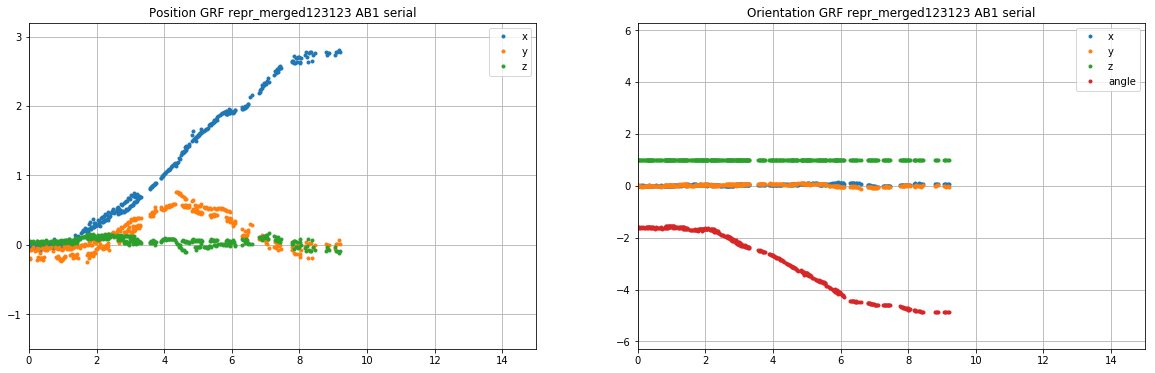

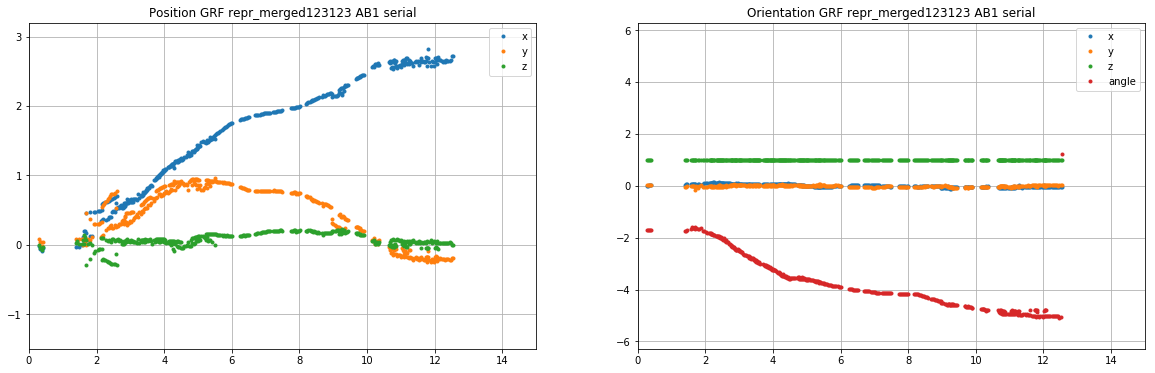

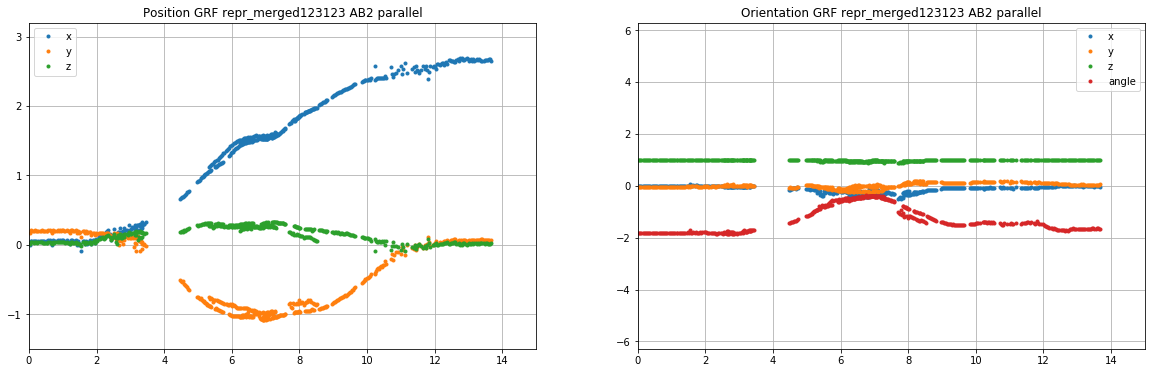

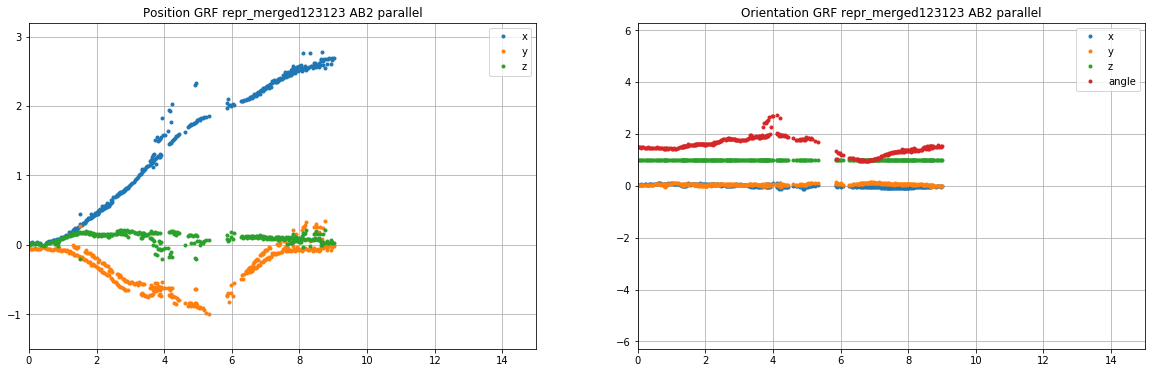

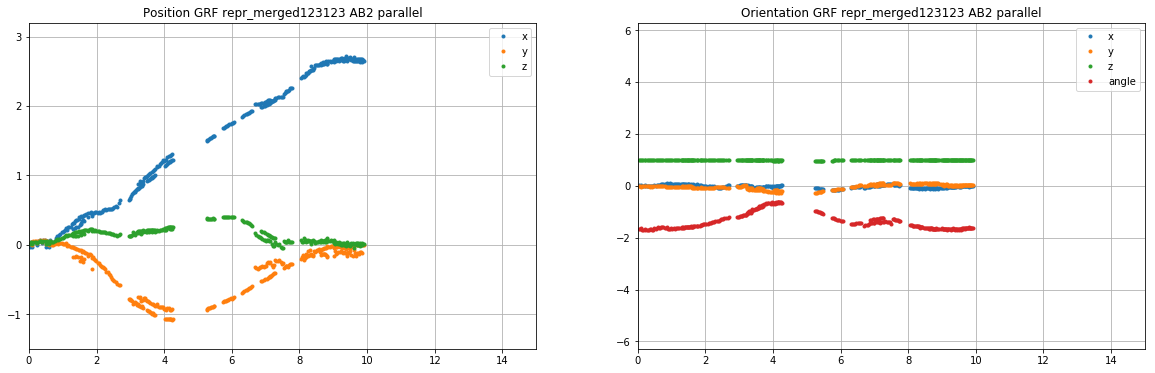

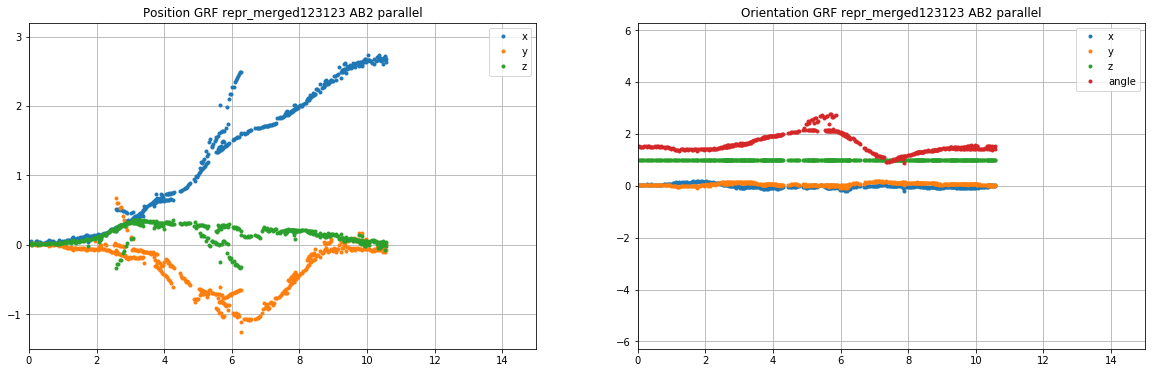

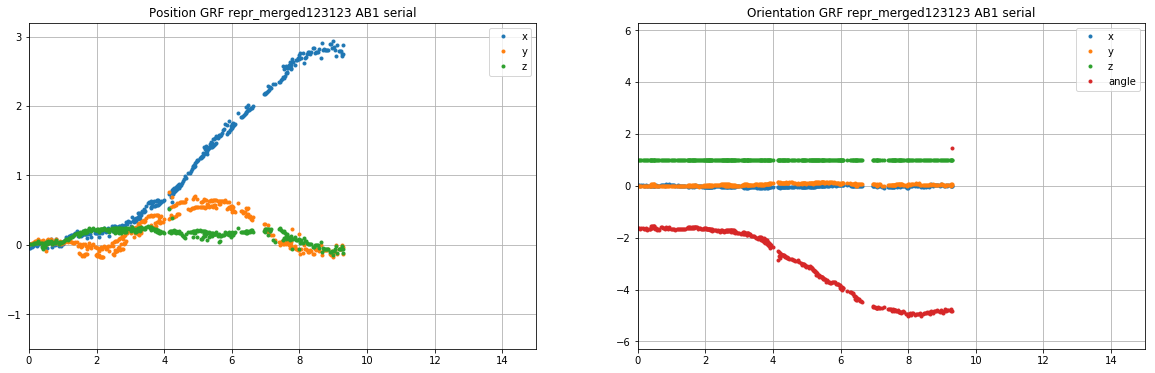

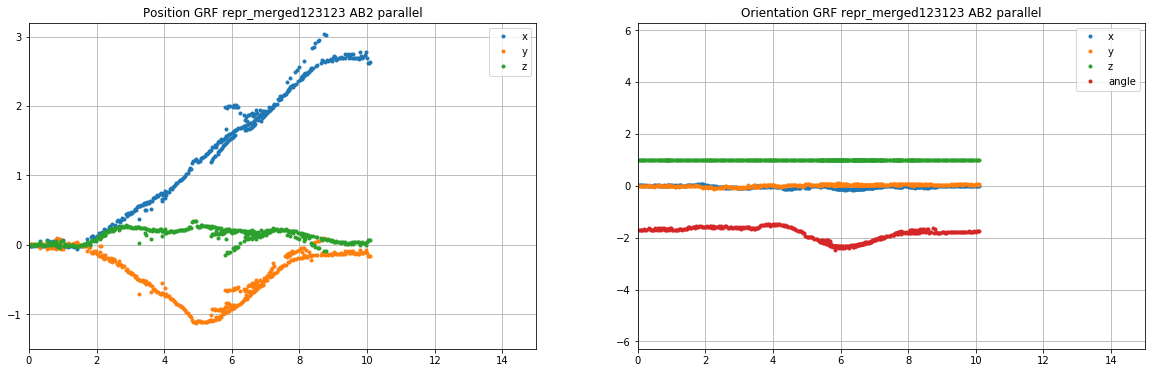

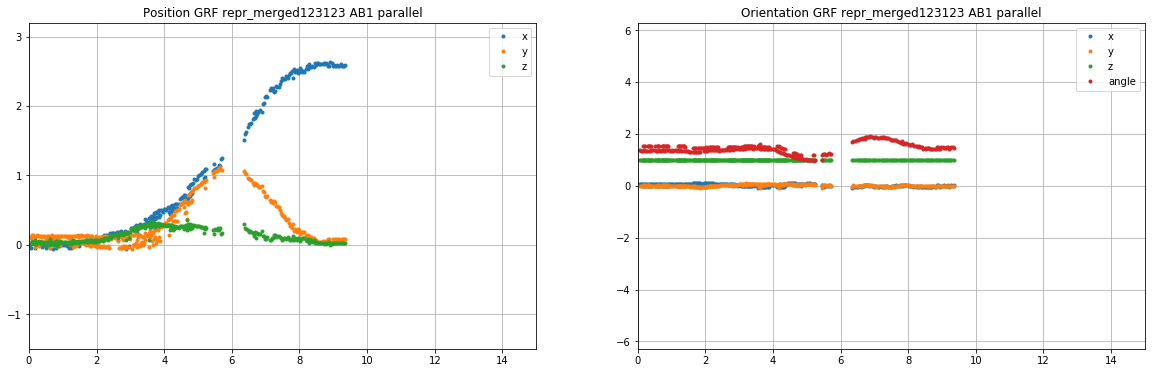

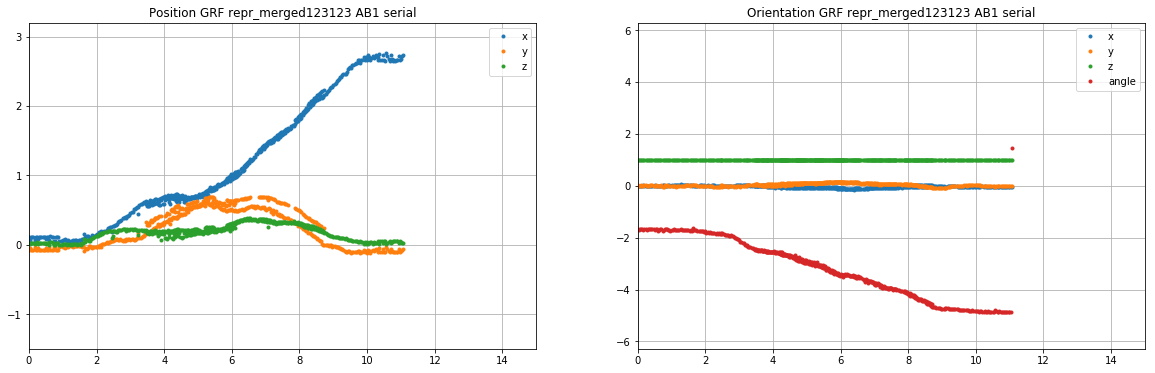

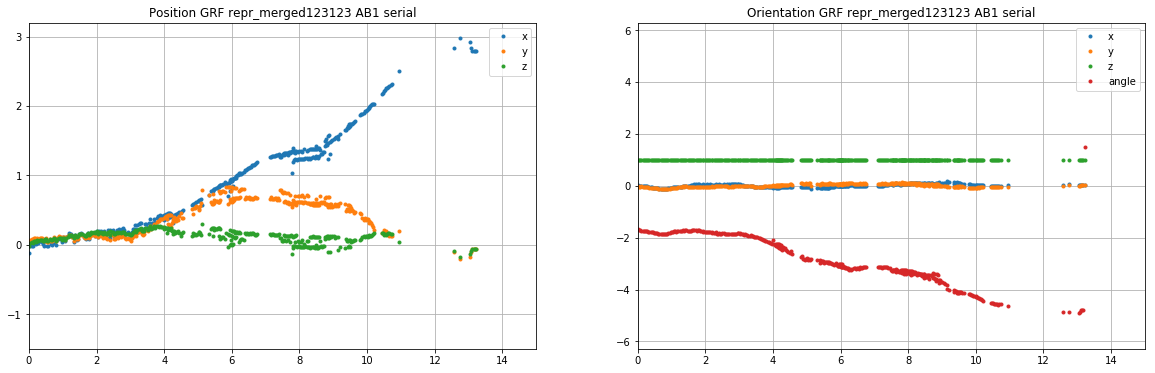

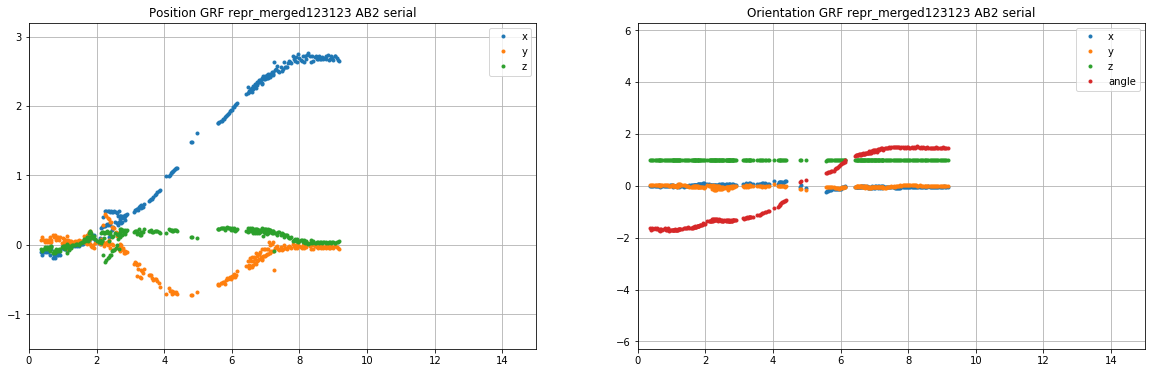

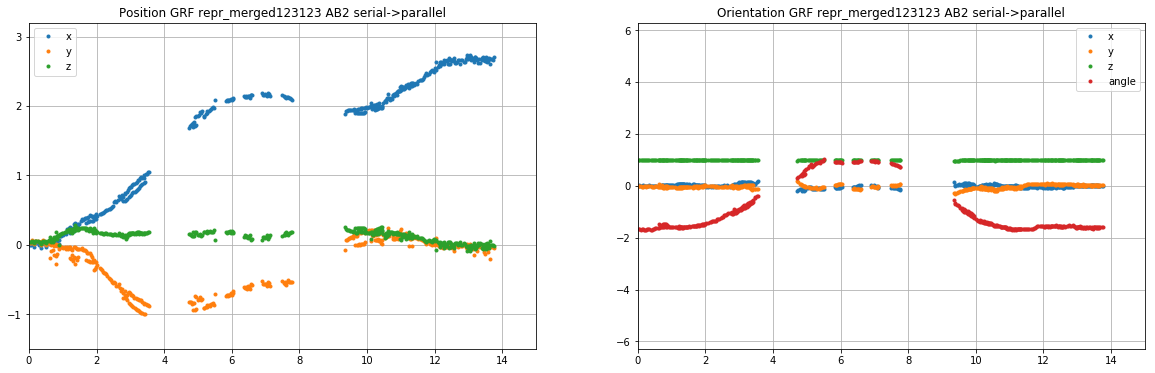

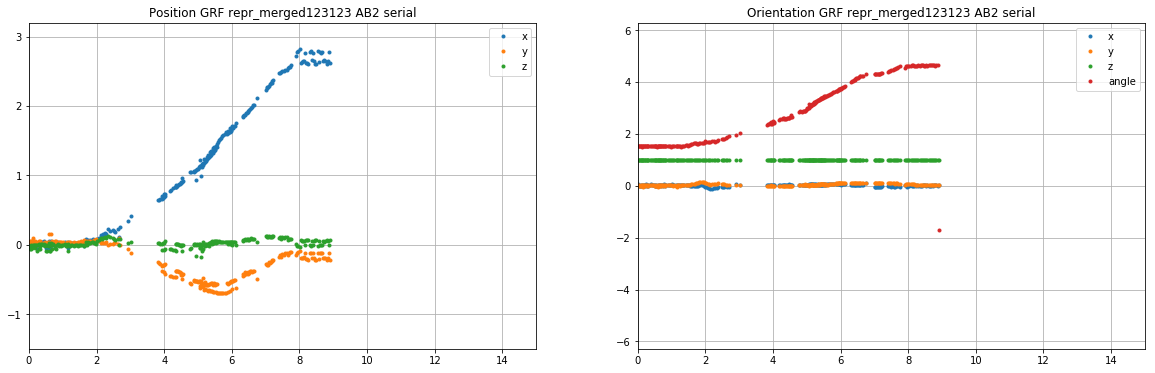

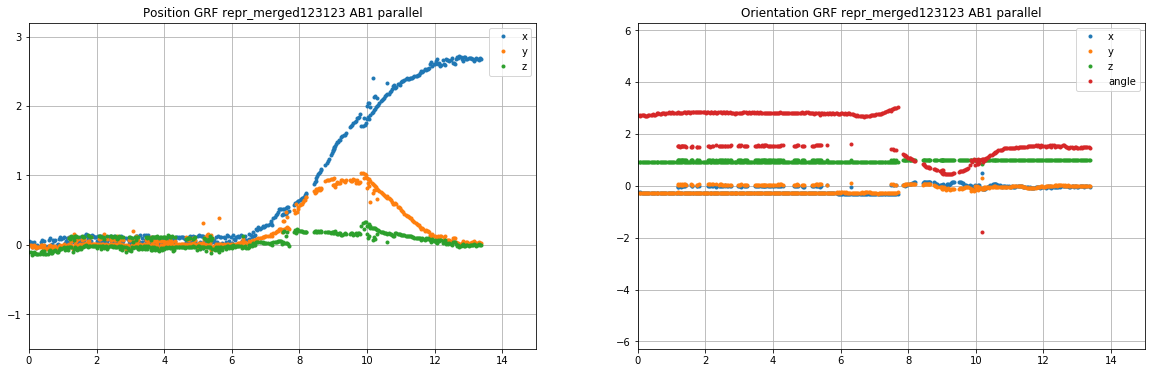

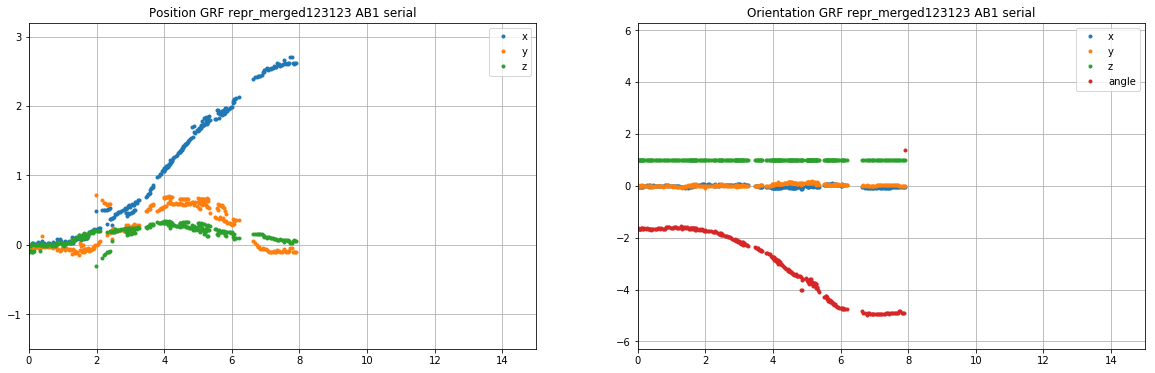

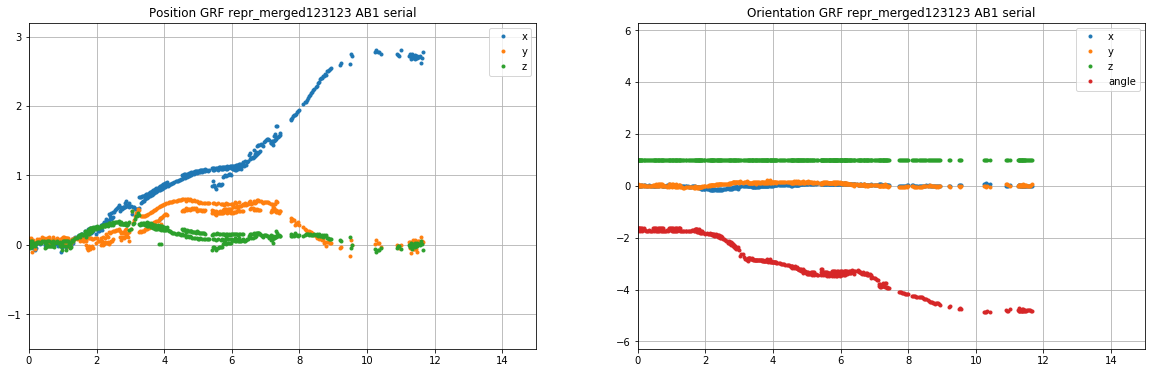

In [23]:
for i in range(len(observations)):
    plot_pose(observations[i])

In [205]:
"""
This module implements the Lowess function for nonparametric regression.
Functions:
lowess Fit a smooth nonparametric regression curve to a scatterplot.
For more information, see
William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.
William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

from math import ceil
import numpy as np
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest


# time derivative
def derivative(x,t):
    diff = np.zeros(x.shape[0])
    for i in range(len(x)-1):
        dx = x[i+1]-x[i]
        dt = t[i+1]-t[i]
        diff[i] = dx/dt
    diff[-1] = diff[-2]
    return diff

def integrate(x,t):
    res = np.zeros(x.shape)
    for i in range(len(res)):
        res[i] = np.trapz(x[:i], t[:i])
    return res

### Kalman Filter on position x

Average Frequency of the position data:  35.68975968308757
Average Frequency of the IMU data:  77.35187386157943


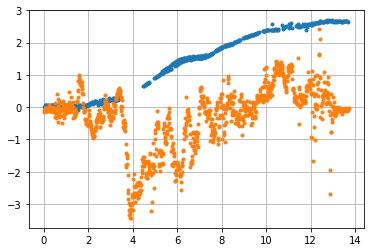

In [269]:
obs = observations[3]

orientation = obs['pose123']['orientation'].copy()
position = obs['pose123']['position'].copy()
tpos = obs['pose123']['time_steps']
freq_pos = tpos.shape[0]/tpos[-1]

imu = obs['imu']
timu = imu['time_steps']
accel = imu['accel']
freq_imu = timu.shape[0]/timu[-1]

print 'Average Frequency of the position data: ', freq_pos
print 'Average Frequency of the IMU data: ', freq_imu

plt.plot(tpos,position[:,0], '.')
plt.grid()

plt.plot(timu,accel[:,0],'.')

### Smoothening

In [270]:
# Interpolate the signals at nominal time
tnom = np.arange(0, tpos[-1], 0.01)

pos_interp = np.zeros((tnom.shape[0],3))
pos_interp[:,0] = np.interp(tnom, tpos, position[:,0])
pos_interp[:,1] = np.interp(tnom, tpos, position[:,1])
pos_interp[:,2] = np.interp(tnom, tpos, position[:,2])

orient_interp = np.zeros((tnom.shape[0],4))
orient_interp[:,0] = np.interp(tnom, tpos, orientation[:,0])
orient_interp[:,1] = np.interp(tnom, tpos, orientation[:,1])
orient_interp[:,2] = np.interp(tnom, tpos, orientation[:,2])
orient_interp[:,3] = np.interp(tnom, tpos, orientation[:,3])


accel_aligned = np.zeros(pos_interp.shape)
accel_aligned[:,0] = np.interp(tnom, timu, accel[:,0])
accel_aligned[:,1] = np.interp(tnom, timu, accel[:,1])
accel_aligned[:,2] = np.interp(tnom, timu, accel[:,2])


In [272]:
# Smoothening
pos_smooth = np.zeros(pos_interp.shape)
pos_smooth[:,0] = lowess(tnom,pos_interp[:,0],f=0.09)
pos_smooth[:,1] = lowess(tnom,pos_interp[:,1],f=0.09)
pos_smooth[:,2] = lowess(tnom,pos_interp[:,2],f=0.09)

orient_smooth = np.zeros((tnom.shape[0],4))
orient_smooth[:,0] = lowess(tnom,orient_interp[:,0],f=0.05)
orient_smooth[:,1] = lowess(tnom,orient_interp[:,1],f=0.05)
orient_smooth[:,2] = lowess(tnom,orient_interp[:,2],f=0.05)
orient_smooth[:,3] = lowess(tnom,orient_interp[:,3],f=0.05)

# Velocity derived from smooth positions
vel_smooth = np.zeros(pos_interp.shape)
vel_smooth[:,0] = derivative(pos_smooth[:,0],tnom)
vel_smooth[:,1] = derivative(pos_smooth[:,1],tnom)
vel_smooth[:,2] = derivative(pos_smooth[:,2],tnom)

accel_smooth = np.zeros(pos_interp.shape)
accel_smooth[:,0] = lowess(tnom,accel_aligned[:,0],f=0.02)
accel_smooth[:,1] = lowess(tnom,accel_aligned[:,1],f=0.02)
accel_smooth[:,2] = lowess(tnom,accel_aligned[:,2],f=0.02)

#### Visual Check of the post processed Data

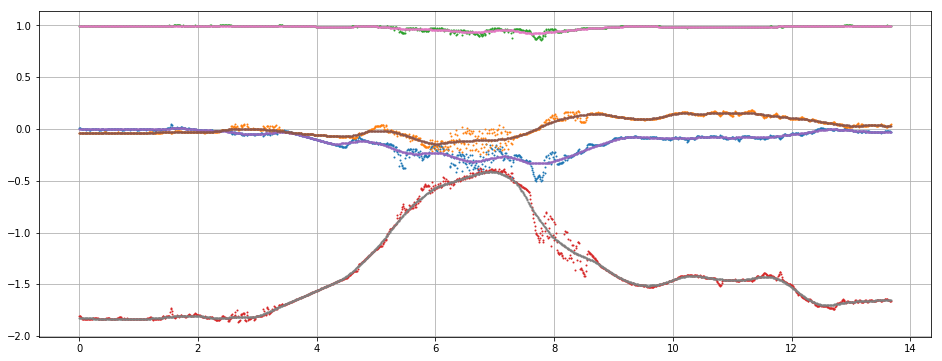

In [273]:
# Orientation
plt.figure(figsize=(16,6))
plt.plot(tnom, orient_interp,'.', MarkerSize=2)
plt.plot(tnom, orient_smooth, '.',MarkerSize=2)
plt.grid()

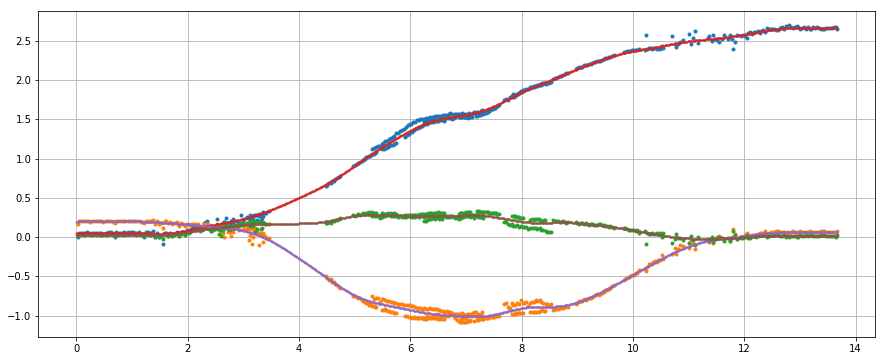

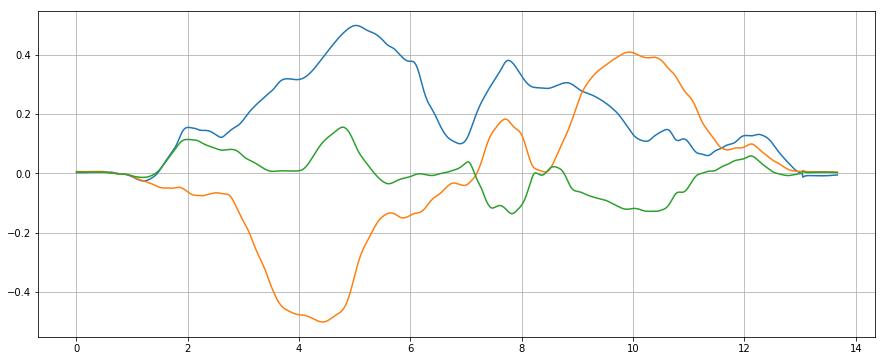

In [274]:
# Position and Velocity
plt.figure(figsize=(15,6))
plt.plot(tpos, position,'.')
plt.plot(tnom, pos_smooth,'.', MarkerSize=2)
plt.grid()

plt.figure(figsize=(15,6))
plt.plot(tnom, vel_smooth, MarkerSize=2)
plt.grid()

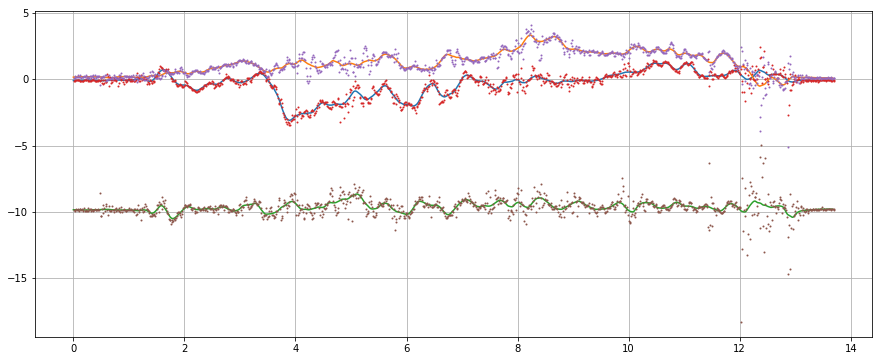

In [275]:
plt.figure(figsize=(15,6))
plt.plot(tnom, accel_smooth)
plt.plot(timu, accel,'.', MarkerSize=2)
plt.grid()

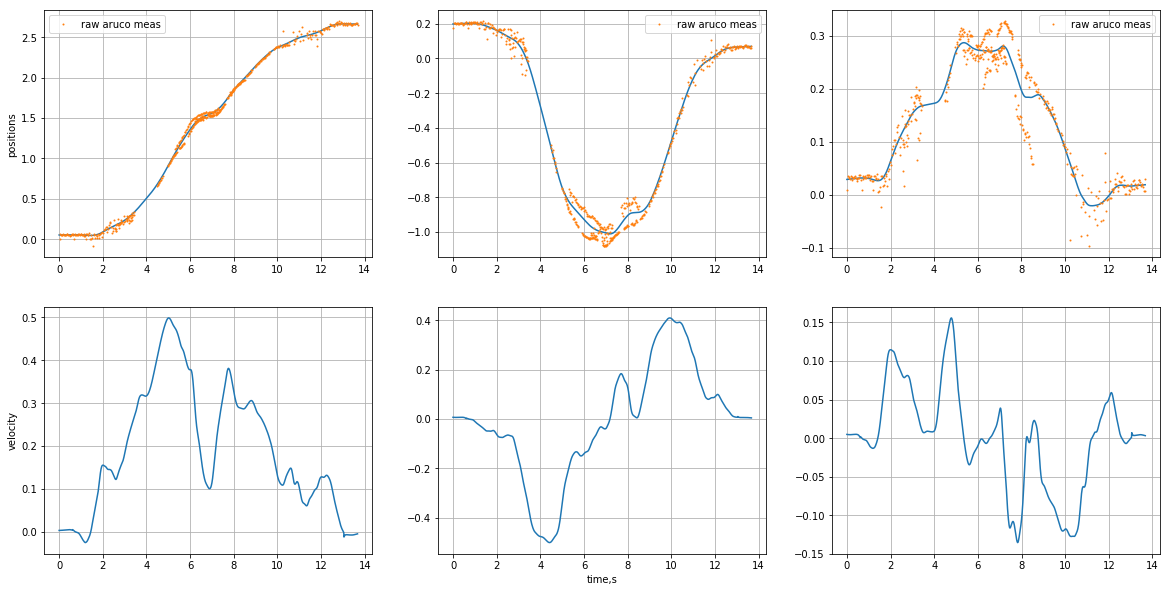

In [276]:
# plot Velocity vs Position

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(tnom, pos_smooth[:,0])
plt.plot(tpos, position[:,0], '.', MarkerSize=2, label='raw aruco meas')
plt.grid()
plt.legend()
plt.ylabel('positions')

plt.subplot(2,3,2)
plt.plot(tnom, pos_smooth[:,1])
plt.plot(tpos, position[:,1], '.', MarkerSize=2, label='raw aruco meas')
plt.grid()
plt.legend()


plt.subplot(2,3,3)
plt.plot(tnom, pos_smooth[:,2])
plt.plot(tpos, position[:,2], '.', MarkerSize=2, label='raw aruco meas')
plt.grid()
plt.legend()

plt.subplot(2,3,4)
plt.plot(tnom, vel_smooth[:,0])
plt.ylabel('velocity')
plt.grid()

plt.subplot(2,3,5)
plt.plot(tnom, vel_smooth[:,1])
plt.xlabel('time,s')
plt.grid()

plt.subplot(2,3,6)
plt.plot(tnom, vel_smooth[:,2])
plt.grid()


#### Transform acceleration from Body frame to Spatial Frame

In [249]:

accel_grf = np.zeros(accel_smooth.shape)
for i, orient in enumerate(orient_smooth):
    rot_mat = rotation_matrix(orient[-1], orient[:3])[:3,:3]
    accel_grf[i,:] = np.matmul(rot_mat, accel_smooth[i])

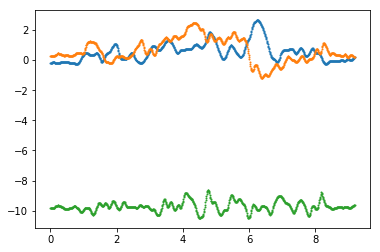

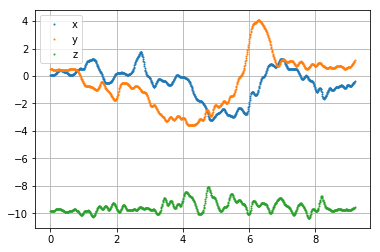

In [250]:
# Corresponding plot
plt.plot(tnom,accel_smooth, '.', MarkerSize=2)

plt.figure()
plt.plot(tnom, accel_grf,'.', MarkerSize=2)
plt.legend(['x','y','z'])
plt.grid()

In [251]:
adev = derivative(vel_smooth[:,0], tnom)
v_integ = integrate(accel_grf[:,1], tnom)

#### Kalman Filter

In [252]:
'''
State vector:
    x = [pos, vel, accel]
    x[t] = A*x[t-1]+w
Measurement:
    z = [pos, acc]
    
A = np.array(
    [[],
     [],
     []])
     
std of accel at rest:
ax        ay        az
0.0387    0.0229    0.0414
'''

# A = lambda i: np.array(
#     [[1,tpos[i]-tpos[i-1], (tpos[i]-tpos[i-1])**2],
#      [0, 1, tpos[i]-tpos[i-1]],
#      [0, 0, 0]])

A = lambda i: np.array(
    [[1,tnom[i]-tnom[i-1], (tnom[i]-tnom[i-1])**2],
     [0, 1, tnom[i]-tnom[i-1]],
     [0, 0, 1]])

# H = np.array(
#     [[1,0,0],
#      [0,0,1]])

H = np.array(
    [[1,0,0],
     [0,1,0],
     [0,0,1]])


B = np.array([0, 0, 1])
g_off = np.array([0,0,-9.86])

In [253]:
N = tnom.shape[0]
# z_meas = np.vstack((position[:,1], accel_grf[:,1])).transpose()
z_meas = np.vstack((pos_smooth[:,0], vel_smooth[:,0], accel_grf[:,0])).transpose()

x_est = np.zeros((N,3))
x_est[0][0] = z_meas[0][0]

# Initial Error
P = np.array(
    [[0.01, 0, 0],
     [0, 0.01, 0],
     [0, 0, 0.01]])

# Process Noise
Q = np.array(
    [[0.01, 0, 0],
     [0, 1., .0],
     [0, 0, .01]])

# Measurement Noise
R = np.array(
    [[.1, 0, 0],
     [0, .5, 0],
     [0, 0, 0.387]])

for i in range(1,N):
    # Predict
    x_ = np.matmul(A(i), x_est[i-1])# + B*z_meas[i,1]
    P_ = np.matmul(np.matmul(A(i),P),A(i).T)+Q
    
    # Update
    Mi = np.linalg.inv(np.matmul(np.matmul(H,P_),H.T)+R)
    K = np.matmul(np.matmul(P_, H.T), Mi)
    x_est[i] = x_+ np.matmul(K, (z_meas[i]-np.matmul(H,x_)))
    
    P = np.matmul((np.eye(3)-np.matmul(K,H)),P_)
    

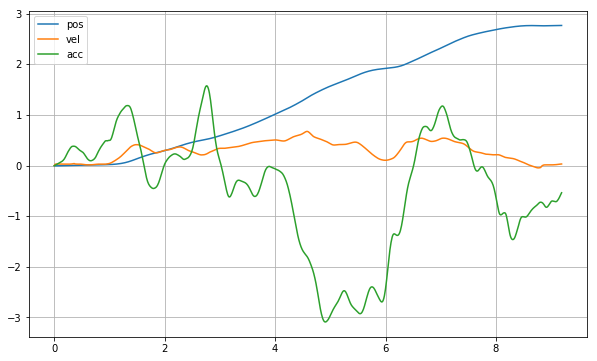

In [254]:
plt.figure(figsize=(10,6))
plt.plot(tnom, x_est)
plt.legend(['pos','vel','acc'])
plt.grid()

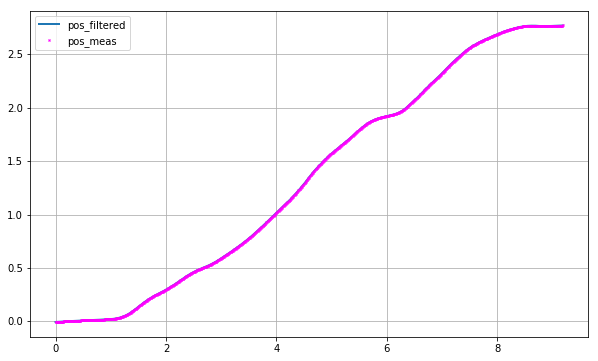

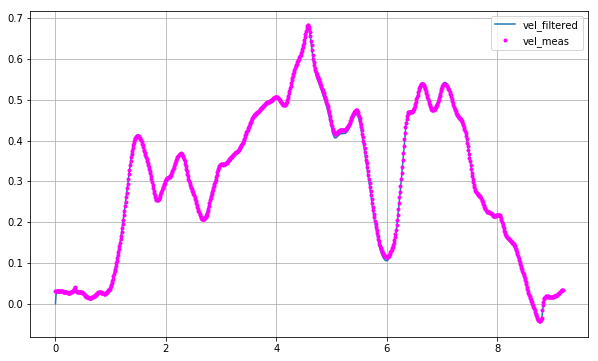

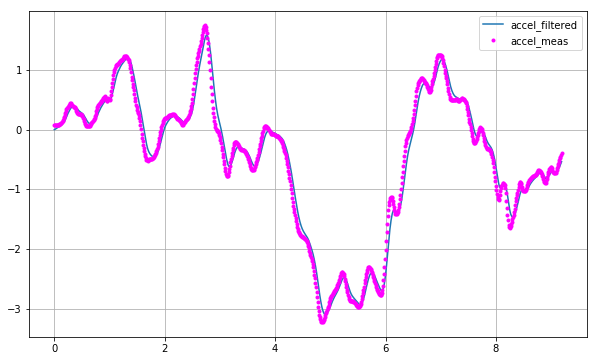

In [255]:
# plt.figure(figsize=(10,6))
# plt.plot(tpos,x_est[:,0], LineWidth=2)
# plt.plot(tpos,z_meas[:,0], 'x', color='magenta', MarkerSize=2)
# plt.legend(['pos_filtered','pos_meas'])
# plt.grid()

# plt.figure(figsize=(10,6))
# plt.plot(tpos,x_est[:,2])
# plt.plot(tpos,z_meas[:,1], '.', color='magenta')
# plt.legend(['accel_filtered','accel_meas'])
# plt.grid()


plt.figure(figsize=(10,6))
plt.plot(tnom,x_est[:,0], LineWidth=2)
plt.plot(tnom,z_meas[:,0], 'x', color='magenta', MarkerSize=2)
plt.legend(['pos_filtered','pos_meas'])
plt.grid()

plt.figure(figsize=(10,6))
plt.plot(tnom,x_est[:,1])
plt.plot(tnom,z_meas[:,1], '.', color='magenta')
plt.legend(['vel_filtered','vel_meas'])
plt.grid()

plt.figure(figsize=(10,6))
plt.plot(tnom,x_est[:,2])
plt.plot(tnom,z_meas[:,2], '.', color='magenta')
plt.legend(['accel_filtered','accel_meas'])
plt.grid()

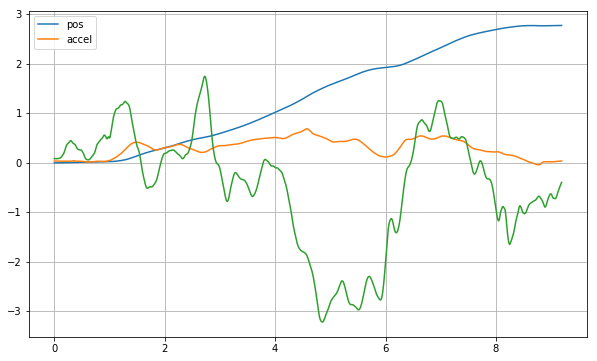

In [256]:
plt.figure(figsize=(10,6))
plt.plot(tnom,z_meas)
plt.legend(['pos','accel'])
plt.grid()

### Filter based on Standard Deviation

In [ ]:
# time derivative
def derivative(x,t):
    diff = np.zeros(x.shape[0]-1)
    for i in range(len(x)-1):
        dx = x[i+1]-x[i]
        dt = t[i+1]-t[i]
        diff[i] = dx/dt
#     diff = diff/np.pi*180
    return diff

In [ ]:
plt.figure()
plt.boxplot((orientation-orient_means)[:,:])
plt.grid()

plt.figure()
plt.boxplot(position-pos_means)
plt.grid()

### Draw All clean

In [ ]:
obs = observations[0]

In [ ]:
plot_all_clean(observations[5])

### Draw merged position

In [ ]:
obs = observations[15]

In [ ]:
h = 6
w = 2
ylim = 1.5
xlim = 15

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,3)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['position'], '*')
plt.legend(['x','y','z'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,4)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['quaternion'], '*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,5)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,6)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,7)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 2 merged %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,8)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['quaternion'],'*')
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,9)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,10)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,11)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,12)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['quaternion'],'*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_merged']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

### Draw position variables

In [ ]:
obs = observations[16]

In [ ]:
h = 3
w = 2
ylim = 1.5
xlim = 18

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,3)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,4)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,5)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,6)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

In [ ]:
obs['pose1_grf']['time_steps'].shape

In [ ]:
tt = np.concatenate((obs['pose1_grf']['time_steps'], obs['pose1_off_grf']['time_steps']))
pp = np.concatenate((obs['pose1_grf']['position'], obs['pose1_off_grf']['position']))
qq = np.concatenate((obs['pose1_grf']['quaternion'], obs['pose1_off_grf']['quaternion']))

In [ ]:
tt.shape, pp.shape

In [ ]:
_, indx = np.unique(tt, return_index=True)

tt = tt[indx]
pp = pp[indx]
sind = np.argsort(tt)
tt = tt[sind]

In [ ]:
tt.shape

In [ ]:
plt.plot(tt[sind],pp[sind])
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],pp[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],qq[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(obs['pose1_grf']['time_steps'],obs['pose1_grf']['position'], '.', MarkerSize=1.2)
plt.xlim(0,xlim)

In [ ]:
tt.shape

### Draw all channels

In [ ]:
h = 10
w = 2

plt.figure(figsize=(20,h*10))

           
print obs['traj_type'], obs['motion_type']

# plt.title('{} {}'.format(obs['traj_type'],obs['motion_type']))

plt.subplot(h,w,1)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Force %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,2)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Torque %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,3)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Force %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,4)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Torque %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,5)
plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Accel %s'%obs['imu']['frame_id'])
plt.grid()


plt.subplot(h,w,6)
plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Gyro %s'%obs['imu']['frame_id'])
plt.grid()

plt.subplot(h,w,7)
plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Mag %s'%obs['imu']['frame_id'])
plt.grid()

# Position from camera 1
plt.subplot(h,w,8)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,9)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()


# Position from camera 2
plt.subplot(h,w,10)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.subplot(h,w,11)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()


# Position from camera 3
plt.subplot(h,w,12)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,13)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()


In [ ]:
# all_observations = all_observations+observations

In [ ]:
# pickle.dump(all_observations, open('segmented_trials.pkl', 'w'))

In [ ]:
# pickle.dump(observations, open('segmented_trials.pkl', 'w'))